# EDA

1. clean and validate data 
2. perform some eda on the data to be able to see what the median baseline is and identify outliers 
3. Are the outliers due to faulty sensors such as a temp of 999 or -999 impossible 
4. remove the outliers and/or replace with median values 


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load files
train = pd.read_csv('train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('SampleSubmission.csv')


In [3]:
train_copy = train.copy()

In [4]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      293563 non-null  float64       
 3   Sensor2_PM2.5      293563 non-null  float64       
 4   Temperature        293628 non-null  float64       
 5   Relative_Humidity  293628 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 15.9+ MB


In [6]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.00000,293563.00000,293628.00000,293628.00000,297177.00000
mean,40.75120,38.18302,23.31655,78.65362,0.37107
std,28.52618,28.64776,3.83697,14.77272,0.48309
min,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,22.43000,19.52000,20.40000,68.00000,0.00000
50%,36.47000,33.72000,21.90000,84.00000,0.00000
75%,49.42000,47.57000,26.30000,91.00000,1.00000
max,997.96000,997.26000,34.90000,99.00000,1.00000


In [7]:
test.shape

(127361, 6)

## Looking at the skewness of the data 


In [8]:
train.shape 

(297177, 7)

In [9]:
sensor1 = train['Sensor1_PM2.5']
sensor2 = train['Sensor2_PM2.5']
temperature = train['Temperature']
relative_humidity = train['Relative_Humidity']
offset_fault = train['Offset_fault']

data before replacing missing numerical values with the means

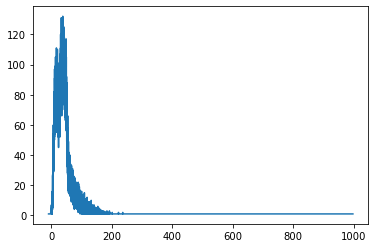

In [10]:
plt.plot(sensor1.value_counts().sort_index())

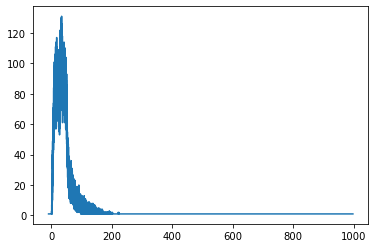

In [11]:
plt.plot(sensor2.value_counts().sort_index())

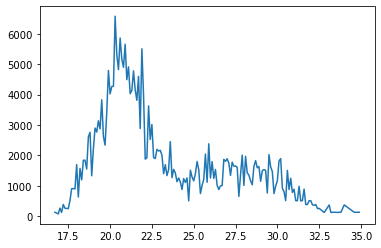

In [12]:
plt.plot(temperature.value_counts().sort_index())

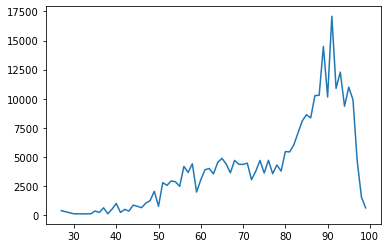

In [13]:
plt.plot(relative_humidity.value_counts().sort_index())

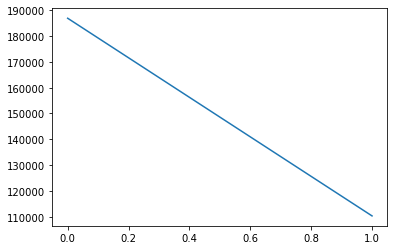

In [14]:
plt.plot(offset_fault.value_counts().sort_index())

Since some of the data above is skewed we will imput the median instead of the mean for the missing data but before that we need to know where the missing data is most prominent is the data missing for a specific date or is it missing when the temparature is low this could lead us to a solution that can help the manufacturer to produce a better performing product in general 

## Looking at the missing values 

### Sensor 1 and 2

In [15]:
missing_sensor1=sensor1.isnull()
train[missing_sensor1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 124 to 296976
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 3614 non-null   object        
 1   Datetime           3614 non-null   datetime64[ns]
 2   Sensor1_PM2.5      0 non-null      float64       
 3   Sensor2_PM2.5      0 non-null      float64       
 4   Temperature        3614 non-null   float64       
 5   Relative_Humidity  3614 non-null   float64       
 6   Offset_fault       3614 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 225.9+ KB


In [16]:
missing_sensor2=sensor2.isnull()
train[missing_sensor2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 124 to 296976
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 3614 non-null   object        
 1   Datetime           3614 non-null   datetime64[ns]
 2   Sensor1_PM2.5      0 non-null      float64       
 3   Sensor2_PM2.5      0 non-null      float64       
 4   Temperature        3614 non-null   float64       
 5   Relative_Humidity  3614 non-null   float64       
 6   Offset_fault       3614 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 225.9+ KB


seems like if a value is missing for sensor 1 it also comes up missing for sensor 2

In [17]:
(train[missing_sensor2]==train[missing_sensor1]).describe()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,3614,3614,3614,3614,3614,3614,3614
unique,1,1,1,1,1,1,1
top,True,True,False,False,True,True,True
freq,3614,3614,3614,3614,3614,3614,3614


In [18]:
train[missing_sensor1].describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,0.00000,0.00000,3614.00000,3614.00000,3614.00000
mean,NaN,NaN,22.82028,81.80160,0.42667
std,NaN,NaN,3.37731,12.75699,0.49466
min,NaN,NaN,18.40000,52.00000,0.00000
25%,NaN,NaN,20.10000,70.00000,0.00000
50%,NaN,NaN,21.60000,88.00000,0.00000
75%,NaN,NaN,25.10000,91.00000,1.00000
max,NaN,NaN,30.80000,97.00000,1.00000


In [19]:
train[missing_sensor1].groupby(train['Datetime'].dt.floor('d'))['ID'].count()

Datetime
2021-10-18    593
2021-10-19    949
2021-10-20    547
2021-10-21    940
2021-10-22    585
Name: ID, dtype: int64

In [20]:
train[missing_sensor2].groupby(train['Datetime'].dt.floor('d'))['ID'].count()

Datetime
2021-10-18    593
2021-10-19    949
2021-10-20    547
2021-10-21    940
2021-10-22    585
Name: ID, dtype: int64

The missing data happens on consecutive days from 18-10-2021 to 22-10-2021 we had already seen that the id's and dates for the sensors 1 and 2 match so the above step was not nessesary but just out of due dilligence. We had already determined that the data for sensor 1 and 2 is skew and liable to be influenced by outliers so i will replace the missing data with the median of the data set in order to side step the skewness matter.

*https://reliefweb.int/report/uganda/uganda-floods-landslides-and-hailstorms-dg-echo-uganda-red-cross-society-iom-office
*As a possible explanation for what happened to the data for these consecutive days 

### Temperature and Humidity

In [21]:
missing_temparature=temperature.isnull()
train[missing_temparature].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3549 entries, 103 to 297083
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 3549 non-null   object        
 1   Datetime           3549 non-null   datetime64[ns]
 2   Sensor1_PM2.5      3549 non-null   float64       
 3   Sensor2_PM2.5      3549 non-null   float64       
 4   Temperature        0 non-null      float64       
 5   Relative_Humidity  0 non-null      float64       
 6   Offset_fault       3549 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 221.8+ KB


There seems to be a correlation between missing temparature data and missing relative humidity data this will need further investigation and i might have to even change my heading for this i named it temperature immaturely. It shall become temparatue and humidity 

In [22]:
missing_humidity=relative_humidity.isnull()
train[missing_humidity].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3549 entries, 103 to 297083
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 3549 non-null   object        
 1   Datetime           3549 non-null   datetime64[ns]
 2   Sensor1_PM2.5      3549 non-null   float64       
 3   Sensor2_PM2.5      3549 non-null   float64       
 4   Temperature        0 non-null      float64       
 5   Relative_Humidity  0 non-null      float64       
 6   Offset_fault       3549 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 221.8+ KB


Indeed the same amount of missing temparature data is also the same as the missing humidity data 

In [23]:
(train[missing_humidity]==train[missing_humidity]).describe()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,3549,3549,3549,3549,3549,3549,3549
unique,1,1,1,1,1,1,1
top,True,True,True,True,False,False,True
freq,3549,3549,3549,3549,3549,3549,3549


In [24]:
train[missing_temparature].describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,3549.00000,3549.00000,0.00000,0.00000,3549.00000
mean,28.42436,27.07261,NaN,NaN,0.44548
std,17.97318,18.56210,NaN,NaN,0.49709
min,3.90000,1.67000,NaN,NaN,0.00000
25%,16.45000,14.22000,NaN,NaN,0.00000
50%,26.35000,23.97000,NaN,NaN,0.00000
75%,35.23000,36.00000,NaN,NaN,1.00000
max,154.85000,153.73000,NaN,NaN,1.00000


In [25]:
train[missing_temparature].groupby(train['Datetime'].dt.floor('d'))['ID'].count()

Datetime
2021-10-30    252
2021-11-24    318
2021-11-26    180
2021-11-30    290
2021-12-21    403
2021-12-23    327
2021-12-29    315
2022-01-08    455
2022-01-09    104
2022-01-12    526
2022-01-19    379
Name: ID, dtype: int64

The plots for the temperature and the humidity are skewed so I believe imputing the median is the best option for these values .

### Offset fault

In [26]:
missing_fault=offset_fault.isnull()
train[missing_fault].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 0 non-null      object        
 1   Datetime           0 non-null      datetime64[ns]
 2   Sensor1_PM2.5      0 non-null      float64       
 3   Sensor2_PM2.5      0 non-null      float64       
 4   Temperature        0 non-null      float64       
 5   Relative_Humidity  0 non-null      float64       
 6   Offset_fault       0 non-null      int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 0.0+ bytes


Offset fault has no missing values

## Replacing Missing values with the median

I found while doing my EDA that the columns with missing data are all skewed you can see this by just looking at the mean and the 50%-median of the data and that difference tells you to which side the data is skewed left or right. Since the coulumns are skewed it would not be wise for me to impute the mean for the missing values as the mean is influenced by outliers and can lead to the shape of the coulumns being changed and an innacurate ml prediction later due to the training set being negatively influenced.

In [27]:
#train.dropna(inplace=True)

In [28]:
values = {'Sensor1_PM2.5': train['Sensor1_PM2.5'].median(), 'Sensor2_PM2.5':train['Sensor2_PM2.5'].median(), 'Temperature': train['Temperature'].median(), 'Relative_Humidity': train['Relative_Humidity'].median()}
print(values)

{'Sensor1_PM2.5': 36.47, 'Sensor2_PM2.5': 33.72, 'Temperature': 21.9, 'Relative_Humidity': 84.0}


In [29]:
#Train
train.fillna(value=values,inplace=True)
#Test
test.fillna(value=values,inplace=True)

In [30]:
train.shape

(297177, 7)

In [31]:
test.shape

(127361, 6)

filling in the missing values removed the offset_fault column and removed multiple rows I do not know how to solve this conundrum I want it back and so my next step will be putting it back into the dataframe so I don't have to do extra steps when i am doing the train test split later on.

In [32]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177.00000,297177.00000,297177.00000,297177.00000,297177.00000
mean,40.69913,38.12874,23.29964,78.71747,0.37107
std,28.35608,28.47724,3.81709,14.69573,0.48309
min,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,22.65000,19.70000,20.40000,68.00000,0.00000
50%,36.47000,33.72000,21.90000,84.00000,0.00000
75%,49.22000,47.38000,26.30000,91.00000,1.00000
max,997.96000,997.26000,34.90000,99.00000,1.00000


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      297177 non-null  float64       
 3   Sensor2_PM2.5      297177 non-null  float64       
 4   Temperature        297177 non-null  float64       
 5   Relative_Humidity  297177 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 15.9+ MB


In [34]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


### Checking the data

In [35]:
sensor1_filled = train['Sensor1_PM2.5']
sensor2_filled = train['Sensor2_PM2.5']
temperature_filled = train['Temperature']
humidity_filled = train['Relative_Humidity']

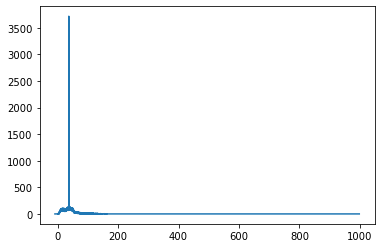

In [36]:
plt.plot(sensor1_filled.value_counts().sort_index())

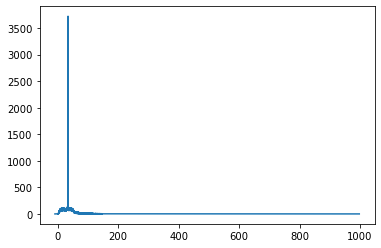

In [37]:
plt.plot(sensor2_filled.value_counts().sort_index())

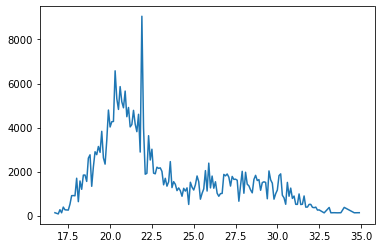

In [38]:
plt.plot(temperature_filled.value_counts().sort_index())

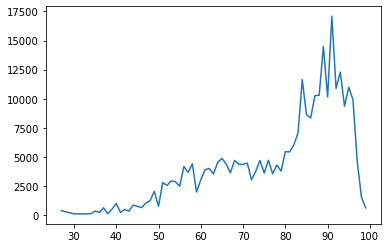

In [39]:
plt.plot(humidity_filled.value_counts().sort_index())

Even though some metrics are alterd we expected this to happen naturaly as you assign values to values that had no value the mean and median are shifted a bit but this is acceptable. But I still need to validate that I have not made a grave error in the way I proceeded so now I will drop the NAN values from a copy table I created earlier. this is not Ideal but since I have the space to accomodate both datasets I see it as fine.What I am expecting to see is a similar summary (.describe()) between the data set with a drop value and the one with the filled in values.

In [40]:
train_copy.dropna(inplace=True)

In [41]:
train_copy.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,290014.00000,290014.00000,290014.00000,290014.00000,290014.00000
mean,40.90204,38.31898,23.32274,78.61439,0.36947
std,28.59837,28.72269,3.84195,14.79190,0.48266
min,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,22.57000,19.62000,20.40000,68.00000,0.00000
50%,36.65000,33.85000,21.90000,84.00000,0.00000
75%,49.55000,47.70000,26.30000,91.00000,1.00000
max,997.96000,997.26000,34.90000,99.00000,1.00000


We see that there is a disparity between the database with the filled values and the database with the dropped values I will use the grader to see which method is the best for handling this disparity.

From the data provided we can see that the target variable Offset_fault has a value of 36,94% from the train copy data this shows that 36,94 % of the sensors are not working and this value is 

## Differences between sensor 1 and 2

In [42]:
((train['Sensor1_PM2.5'].mean()+train['Sensor2_PM2.5'].mean())/2)==((train_copy['Sensor1_PM2.5'].mean()+train_copy['Sensor2_PM2.5'].mean())/2)

False

In [43]:
((train['Sensor1_PM2.5'].median()+train['Sensor2_PM2.5'].median())/2)==((train_copy['Sensor1_PM2.5'].median()+train_copy['Sensor2_PM2.5'].median())/2)

False

mean and median of the filled in comparison with the mean and median of the dropped missing values data

In [44]:
print(((train['Sensor1_PM2.5'].mean()+train['Sensor2_PM2.5'].mean())/2),((train['Sensor1_PM2.5'].median()+train['Sensor2_PM2.5'].median())/2))
print("difference")
print(((train_copy['Sensor1_PM2.5'].mean()+train_copy['Sensor2_PM2.5'].mean())/2),((train_copy['Sensor1_PM2.5'].median()+train_copy['Sensor2_PM2.5'].median())/2) )

39.413937182219684 35.095
difference
39.6105115787514 35.25


In [45]:
# Train
train['Sensor_average']=(train['Sensor1_PM2.5']+train['Sensor2_PM2.5'])/2
# Test
test['Sensor_average']=(test['Sensor1_PM2.5']+test['Sensor2_PM2.5'])/2

The means of the two databases are identical and their medians too but i will look at it more in debth when predicting 

In [46]:
train.shape

(297177, 8)

In [47]:
train_copy.shape

(290014, 7)

## Prepping for Machine learning

I want my data to be as close as possible to a normal distribution as possible before we engage in machine learning so there are two ways to go about this using a transformer on the data in the machine learning pipeline or transforming the data before machine learning even starts. I will be transforming the data before engaging in machine learning for better piece of mind and so that I can internally also be present in the moment

In [48]:
#Train
train['natural_log_Sensor1'] = np.log(train['Sensor1_PM2.5']+1)
train['natural_log_Sensor2'] = np.log(train['Sensor2_PM2.5']+1)

#Test
test['natural_log_Sensor1'] = np.log(test['Sensor1_PM2.5']+1)
test['natural_log_Sensor2'] = np.log(test['Sensor2_PM2.5']+1)

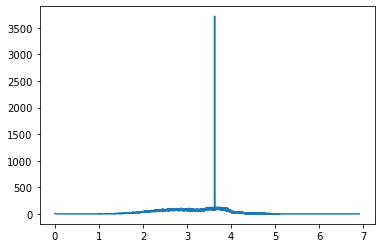

In [49]:
plt.plot(train['natural_log_Sensor1'].value_counts().sort_index())

In [50]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Sensor_average,natural_log_Sensor1,natural_log_Sensor2
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0,51.05000,3.98118,3.92237
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0,34.32500,3.59044,3.53806
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0,21.34000,3.00469,3.19867
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0,17.44000,3.01553,2.80215
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0,36.53500,3.67122,3.57711


I want to eliminate any natural log that falls in the +3 std from the mean range to get a better more harmonious looking natural distribution for thhe data and in so doing i will also be eliminating the extreme outliers in the data I will do this for the sensor1 and sensor2 coulumns numeric column in the dataframe. I will use PowerTransfromer for the humidity and temparature columns

In [51]:
# Train

train['z_score_Sensor1'] = abs((train['natural_log_Sensor1'] - train['natural_log_Sensor1'].mean())/train['natural_log_Sensor1'].std(ddof=0))
train['z_score_Sensor2'] = abs((train['natural_log_Sensor2'] - train['natural_log_Sensor2'].mean())/train['natural_log_Sensor2'].std(ddof=0))

# Test

test['z_score_Sensor1'] = abs((test['natural_log_Sensor1'] - test['natural_log_Sensor1'].mean())/test['natural_log_Sensor1'].std(ddof=0))
test['z_score_Sensor2'] = abs((test['natural_log_Sensor2'] - test['natural_log_Sensor2'].mean())/test['natural_log_Sensor2'].std(ddof=0))

In [52]:
train.shape

(297177, 12)

Adjustment done after ml
I noticed that the code values the sensor 2 pm25 more than the other columns thus this leads me to think that if i can get the difference of this column with the sensor 1 coulmn column tha and get the standard deviation of that It could give my ml model more rigidity and backbone  

In [53]:
#Train
train['std_difference_sensor2_mean']= abs(train['Sensor1_PM2.5']-train['Sensor1_PM2.5'])
train['std_difference_sensor2_mean']= train['std_difference_sensor2_mean'].std(ddof=0)

#Test
test['std_difference_sensor2_mean']= abs(test['Sensor1_PM2.5']-test['Sensor1_PM2.5'])
test['std_difference_sensor2_mean']= test['std_difference_sensor2_mean'].std(ddof=0)

I will be removing the outliers identified by that are outside 3 standard deviations from the mean

In [54]:
# Train
train=train[train['z_score_Sensor1']<=3]
train=train[train['z_score_Sensor2']<=3]
#Test
#test=test[test['z_score_Sensor1']<=3]
#test=test[test['z_score_Sensor2']<=3]

In [55]:
train.shape

(295325, 13)

In [56]:
test.shape

(127361, 12)

In [57]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Sensor_average,natural_log_Sensor1,natural_log_Sensor2,z_score_Sensor1,z_score_Sensor2,std_difference_sensor2_mean
count,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000,295325.00000
mean,40.71572,38.13623,23.28425,78.76829,0.36875,39.42597,3.54783,3.45725,0.75471,0.76202,0.00000
std,26.04644,26.18596,3.80969,14.67373,0.48247,25.79976,0.62496,0.67410,0.61022,0.60207,0.00000
min,3.98000,2.92000,16.70000,27.00000,0.00000,3.50000,1.60543,1.36609,0.00011,0.00007,0.00000
25%,22.95000,19.93000,20.40000,68.00000,0.00000,21.61000,3.17597,3.04118,0.26927,0.29455,0.00000
50%,36.47000,33.72000,21.90000,84.00000,0.00000,35.09500,3.62354,3.54732,0.58187,0.61203,0.00000
75%,49.28000,47.47000,26.20000,91.00000,1.00000,48.32500,3.91761,3.88095,1.12575,1.09884,0.00000
max,236.10000,250.22000,34.90000,99.00000,1.00000,229.55000,5.46848,5.52633,2.99964,2.99681,0.00000


In [58]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Sensor_average,natural_log_Sensor1,natural_log_Sensor2,z_score_Sensor1,z_score_Sensor2,std_difference_sensor2_mean
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0,51.05000,3.98118,3.92237,0.68930,0.68634,0.00000
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0,34.32500,3.59044,3.53806,0.08258,0.13275,0.00000
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0,21.34000,3.00469,3.19867,0.82693,0.35613,0.00000
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0,17.44000,3.01553,2.80215,0.81010,0.92732,0.00000
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0,36.53500,3.67122,3.57711,0.20802,0.18900,0.00000


## Preprocessing 

In [59]:
#Train
train['Datetime_day'] = train.Datetime.dt.day
train['Datetime_month'] = train.Datetime.dt.month
train['Datetime_hour'] = train.Datetime.dt.hour
#Test
test['Datetime_day'] = test.Datetime.dt.day
test['Datetime_month'] = test.Datetime.dt.month
test['Datetime_hour'] = test.Datetime.dt.hour

In [60]:
train_feats = ['Sensor1_PM2.5','Sensor2_PM2.5','Temperature','Relative_Humidity','Sensor_average',\
               'natural_log_Sensor1',"natural_log_Sensor2",'Datetime_month','Datetime_day','Datetime_hour','z_score_Sensor1','z_score_Sensor2','std_difference_sensor2_mean']


In [61]:
X = train[train_feats]
y = train.Offset_fault

# Modelling

In [62]:
# Number of trees in random forest
n_estimators = [67]
# Number of features to consider at every split
max_features = ['log2']
# Maximum number of levels in tree
max_depth = [25]
# Minimum number of samples required to split a node
min_samples_split = [6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]

In [63]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [64]:
'''pt=PowerTransformer(method='yeo-johnson') 
X_power=pt.fit_transform(X)
X=pd.DataFrame(X_power,columns=X.columns)'''

"pt=PowerTransformer(method='yeo-johnson') \nX_power=pt.fit_transform(X)\nX=pd.DataFrame(X_power,columns=X.columns)"

## Spliting train data in to train and test and finding best params

In [65]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.001, random_state = 0)

#Instantiating the model
clf1 = RandomForestClassifier(random_state=0)
clf_grid = GridSearchCV(estimator = clf1, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
clf_grid.fit(X_train, y_train)
clf_grid.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 67}

After instansiating the model multiple times I have found the best hyperparameters to be    I will now bypass gridsearchcv and put these parameters directly into the randomforest classifier

In [66]:
clf=clf_grid.best_estimator_

In [67]:
# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.9628378378378378


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       195
           1       0.95      0.94      0.95       101

    accuracy                           0.96       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.96      0.96      0.96       296



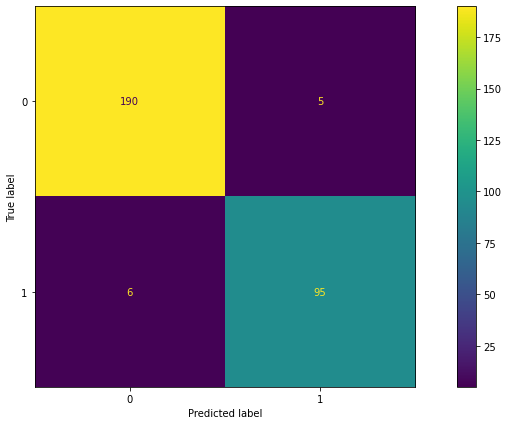

In [68]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

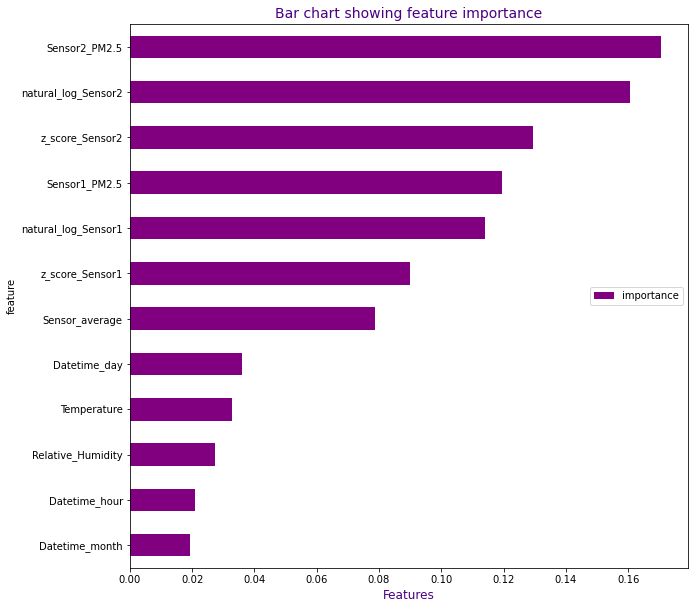

In [69]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

## Making predictions of the test set and creating a submission file

this step i remove all skewness from the data using powertransfrormer I then restate all the coulumns of the data and turn it back into a dataframe 

In [70]:
test_df = test[train_feats]
'''X_power=pt.fit_transform(test_df)
test_df=pd.DataFrame(X_power,columns=X.columns)'''

'X_power=pt.fit_transform(test_df)\ntest_df=pd.DataFrame(X_power,columns=X.columns)'

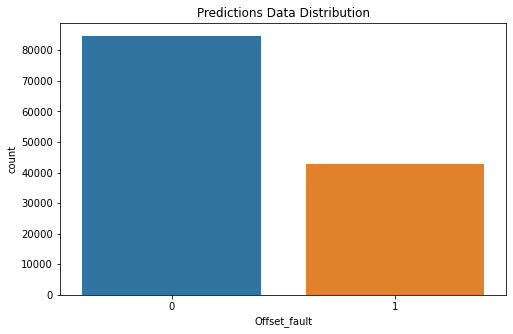

In [71]:
# Make prediction on the test set
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

In [72]:
# Create file
sub_file.to_csv('Baseline.csv', index = False)

Notes at the end of the competition 
Great experience I enjoyed this so much it really played on my competetive spirit and i could not believe by the second day how excited i was to get up and work on my code i loved this experience to flex my machine learning mucle

self notes for the code it is sloppy but it works i first added more features to the code before I started with the machine learning model i saught to naturalize the data first and then utalise techniques to make the things happen This is the first machine learning model that I have made on my own so I kept it simple (More understandable for myself ) I could have also used pipelines and such to streamline the code. I tried and sadly find it too confusing if it is not directly infront of me.